In [1]:
import CRA as CRA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load data
data = CRA.load_BankData()

# Display the first few rows of the data to understand its structure
print(data.head())

    IDRSSD                        name mutual  trust    rssdhcr        date  \
0   991340             1st Source Bank  Stock      1  1199602.0  2001-12-31   
1   282208       Abington Savings Bank  Stock      0  2521741.0  2001-12-31   
2     5210  Adams County National Bank  Stock      1  1117464.0  2001-12-31   
3   774730              Admiralty Bank  Stock      0  2142548.0  2001-12-31   
4  2079493                Advance Bank  Stock      1  1137060.0  2001-12-31   

      TII  nonII   nonIE  staff  ...    equity    TCOs  tot_recoveries  \
0  236773  72464  112798   1135  ...  320511.0  3598.0             188   
1   50492  12328   25420    277  ...   51238.0    73.0              37   
2   39161   3298   13975    168  ...   61521.0   167.0              52   
3   30363   1167   11839    117  ...   42775.0     9.0               0   
4   41168   3964   19838    246  ...   48741.0  3853.0              39   

   offices  ones  dflt_date  default  equity_assets  nonII_assets  TCOs_loans  


In [2]:
# Set up target variable 'y'
y = data['default']
x = data[['equity_assets', 'TCOs_loans', 'nonII_assets']].copy()

# Initialize results list
results = []

In [3]:
# Convert 'x' to a numpy array
x = np.array(x)

# Split the data into training and validation sets (80-20 split)
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

# Function to collect performance metrics
def performStats(model_in):
    PD_val = model_in.predict(x_val).flatten()
    PD_train = model_in.predict(x_train).flatten()
        
    # Limit predictions to avoid log(0) issues
    PD_val = np.clip(PD_val, 1e-15, 1 - 1e-15)
    PD_train = np.clip(PD_train, 1e-15, 1 - 1e-15)
        
    loglike_val =  sum( np.log(PD_val)*y_val + np.log(1-PD_val)*(1-y_val) )  
    AUC_val = roc_auc_score(y_val,PD_val)
    AR_val = 2*(AUC_val-.5)

    loglike_train =  sum( np.log(PD_train)*y_train + np.log(1-PD_train)*(1-y_train) )  
    AUC_train = roc_auc_score(y_train,PD_train)
    AR_train = 2*(AUC_train-.5)
    parms = model_in.count_params()
    result = {'AUC_val':AUC_val,'AR_val':AR_val,"ll_val":loglike_val,  
                  'AUC_train':AUC_train,'AR_train':AR_train,"ll_train":loglike_train,"parms":parms,
                  'obs_train':len(x_train),"obs_val":len(x_val)}
    return(result)
    
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_AUC', mode='max', verbose=0, patience=20,
                                      restore_best_weights=True)
    
# Experiment with different settings
activations = ['relu', 'tanh']
output_activations = ['sigmoid', 'linear']
nodes = [10, 20, 30]
optimizer_classes = [Adam, RMSprop]
    
for activation in activations:
    for output_activation in output_activations:
        for node in nodes:
            for optimizer_class in optimizer_classes:
                key=f'Training model with {node} nodes, {activation} activation, {output_activation} output activation, {optimizer_class.__name__} optimizer'
                print(f'Training with {key}')
                optimizer = optimizer_class()

                model = Sequential([
                    Input(shape=(x_train.shape[1],)), 
                    Dense(node, activation=activation),
                    Dense(1, activation=output_activation)
                    ])
                model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
                    
                model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
                
                stats= performStats(model)
                #stats['config'] = key 
                stats['node'] = node
                stats['activation'] = activation
                stats['output_activation'] = output_activation
                stats['optimizer'] = optimizer_class.__name__
                results.append(stats)

x_train shape: (19156, 3)
x_val shape: (4789, 3)
y_train shape: (19156,)
y_val shape: (4789,)
Training with Training model with 10 nodes, relu activation, sigmoid output activation, Adam optimizer
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training with Training model with 10 nodes, relu activation, sigmoid output activation, RMSprop optimizer
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training with Training model with 20 nodes, relu activation, sigmoid output activation, Adam optimizer
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training with Training model with 20 nodes, relu activation, sigmoid output activation, RMSprop optimizer
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training with Training model with 30 nodes, relu activation, sigmoid output activation, Adam optimizer
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
599/599 ━━━━━━━━

In [4]:
results_df = pd.DataFrame(results)
print(results_df)

     AUC_val    AR_val      ll_val  AUC_train  AR_train     ll_train  parms  \
0   0.838707  0.677414 -291.633656   0.796691  0.593381 -1250.855513     51   
1   0.946563  0.893126  -93.620357   0.904161  0.808321  -540.694761     51   
2   0.946442  0.892883  -87.693278   0.914099  0.828198  -507.663236    101   
3   0.933278  0.866556 -177.325850   0.874456  0.748912  -815.893322    101   
4   0.928269  0.856538 -262.720421   0.859725  0.719450 -1139.489866    151   
5   0.931060  0.862121 -184.809655   0.868207  0.736414  -843.589647    151   
6   0.498008 -0.003983 -656.638462   0.498635 -0.002729 -3593.397264     51   
7   0.500000  0.000000 -656.236752   0.499921 -0.000157 -3592.060735     51   
8   0.950645  0.901291 -416.599936   0.910583  0.821167 -1735.420558    101   
9   0.499790 -0.000419 -656.291862   0.499843 -0.000315 -3592.949124    101   
10  0.500000  0.000000 -656.236752   0.499921 -0.000157 -3592.071445    151   
11  0.500000  0.000000 -656.236752   0.500000  0.000

In [5]:
# Calculate AIC
results_df['AIC_train'] = -2 * results_df['ll_train'] + 2 * results_df['parms']
results_df['AIC_val']= -2 * results_df['ll_val'] + 2 * results_df['parms']

# Calculate AIC weights
min_aic_train=results_df['AIC_train'].min()
results_df['AIC_weight_train'] = np.exp((min_aic_train-results_df['AIC_train']) / 2) / np.exp((min_aic_train-results_df['AIC_train']) / 2).sum()

min_aic_val=results_df['AIC_val'].min()
results_df['AIC_weight_val'] = np.exp((min_aic_val-results_df['AIC_val']) / 2) / np.exp((min_aic_val-results_df['AIC_val']) / 2).sum()

# Calculate the number of defaults
results_df['dflts_train']=y_train.sum()
results_df['dflts_val']=y_val.sum()

print(results_df)

     AUC_val    AR_val      ll_val  AUC_train  AR_train     ll_train  parms  \
0   0.838707  0.677414 -291.633656   0.796691  0.593381 -1250.855513     51   
1   0.946563  0.893126  -93.620357   0.904161  0.808321  -540.694761     51   
2   0.946442  0.892883  -87.693278   0.914099  0.828198  -507.663236    101   
3   0.933278  0.866556 -177.325850   0.874456  0.748912  -815.893322    101   
4   0.928269  0.856538 -262.720421   0.859725  0.719450 -1139.489866    151   
5   0.931060  0.862121 -184.809655   0.868207  0.736414  -843.589647    151   
6   0.498008 -0.003983 -656.638462   0.498635 -0.002729 -3593.397264     51   
7   0.500000  0.000000 -656.236752   0.499921 -0.000157 -3592.060735     51   
8   0.950645  0.901291 -416.599936   0.910583  0.821167 -1735.420558    101   
9   0.499790 -0.000419 -656.291862   0.499843 -0.000315 -3592.949124    101   
10  0.500000  0.000000 -656.236752   0.499921 -0.000157 -3592.071445    151   
11  0.500000  0.000000 -656.236752   0.500000  0.000

Top 5 Best Models based on Validation AUC
     AUC_val    AR_val      ll_val  AUC_train  AR_train     ll_train  parms  \
8   0.950645  0.901291 -416.599936   0.910583  0.821167 -1735.420558    101   
1   0.946563  0.893126  -93.620357   0.904161  0.808321  -540.694761     51   
2   0.946442  0.892883  -87.693278   0.914099  0.828198  -507.663236    101   
13  0.939314  0.878627 -166.144229   0.885522  0.771045  -775.086687     51   
17  0.938784  0.877568 -119.961316   0.876778  0.753555  -629.963105    151   

    obs_train  obs_val  node activation output_activation optimizer  \
8       19156     4789    20       relu            linear      Adam   
1       19156     4789    10       relu           sigmoid   RMSprop   
2       19156     4789    20       relu           sigmoid      Adam   
13      19156     4789    10       tanh           sigmoid   RMSprop   
17      19156     4789    30       tanh           sigmoid   RMSprop   

      AIC_train      AIC_val  AIC_weight_train  AIC_weig

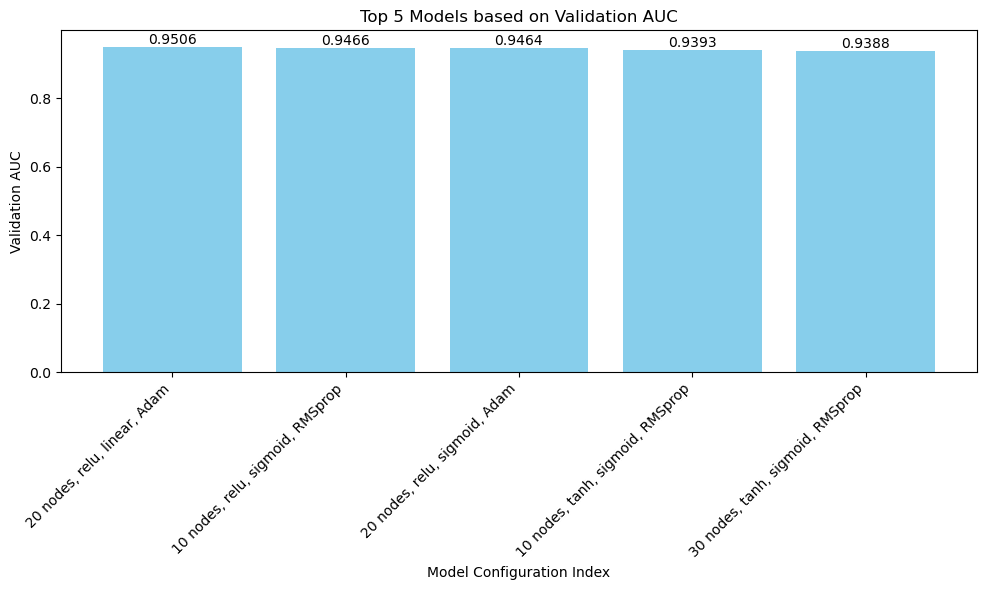

In [6]:
# Step 3: Get best models based on AUC_val
best_models_auc_val = results_df.sort_values(by='AUC_val', ascending=False).head()
print("Top 5 Best Models based on Validation AUC")
print(best_models_auc_val)

# Visualization
plt.figure(figsize=(10, 6))  
best_models_auc_val = best_models_auc_val.reset_index(drop=True)

bars=plt.bar(best_models_auc_val.index, best_models_auc_val['AUC_val'], color='skyblue')

plt.title('Top 5 Models based on Validation AUC')
plt.xlabel('Model Configuration Index')
plt.ylabel('Validation AUC')

plt.xticks(
    ticks=best_models_auc_val.index,
    labels=[f"{row['node']} nodes, {row['activation']}, {row['output_activation']}, {row['optimizer']}" for idx, row in best_models_auc_val.iterrows()],
    rotation=45,
    ha='right'
)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [21]:
best_n_worst_models_auc_val = results_df.sort_values(by='AUC_val', ascending=False)
print(best_n_worst_models_auc_val)
print("Compare Top 3 Best Models and Top 3 Worst Model based on Validation AUC")
print(CRA.head_n_tail(best_n_worst_models_auc_val))

     AUC_val    AR_val      ll_val  AUC_train  AR_train     ll_train  parms  \
8   0.950645  0.901291 -416.599936   0.910583  0.821167 -1735.420558    101   
1   0.946563  0.893126  -93.620357   0.904161  0.808321  -540.694761     51   
2   0.946442  0.892883  -87.693278   0.914099  0.828198  -507.663236    101   
13  0.939314  0.878627 -166.144229   0.885522  0.771045  -775.086687     51   
17  0.938784  0.877568 -119.961316   0.876778  0.753555  -629.963105    151   
15  0.934845  0.869690 -119.336630   0.868178  0.736356  -631.899529    101   
14  0.934028  0.868057 -172.678255   0.862026  0.724052  -798.894731    101   
3   0.933278  0.866556 -177.325850   0.874456  0.748912  -815.893322    101   
21  0.933256  0.866512 -136.557603   0.866256  0.732513 -1146.738580    101   
16  0.932153  0.864305 -152.329663   0.867521  0.735042  -725.428399    151   
5   0.931060  0.862121 -184.809655   0.868207  0.736414  -843.589647    151   
4   0.928269  0.856538 -262.720421   0.859725  0.719

In [7]:
# Step 4: Split results into in-sample and out-of-sample DataFrames
in_sample_df = results_df[['node', 'activation', 'output_activation', 'optimizer','obs_train', 'dflts_train', 'AUC_train', 'AR_train', 'll_train', 'parms','AIC_train','AIC_weight_train']]
out_sample_df = results_df[['node', 'activation', 'output_activation', 'optimizer','obs_val', 'dflts_val', 'AUC_val', 'AR_val', "ll_val", "parms", 'AIC_val','AIC_weight_val']]

# Display in-sample and out-sample results
print("In-Sample Results:")
print(in_sample_df)

print("Out-of-Sample Results:")
print(out_sample_df)

In-Sample Results:
    node activation output_activation optimizer  obs_train  dflts_train  \
0     10       relu           sigmoid      Adam      19156          104   
1     10       relu           sigmoid   RMSprop      19156          104   
2     20       relu           sigmoid      Adam      19156          104   
3     20       relu           sigmoid   RMSprop      19156          104   
4     30       relu           sigmoid      Adam      19156          104   
5     30       relu           sigmoid   RMSprop      19156          104   
6     10       relu            linear      Adam      19156          104   
7     10       relu            linear   RMSprop      19156          104   
8     20       relu            linear      Adam      19156          104   
9     20       relu            linear   RMSprop      19156          104   
10    30       relu            linear      Adam      19156          104   
11    30       relu            linear   RMSprop      19156          104   
12    

Interpretation of the Tables

***Are the in-sample results different than the out-of-sample results?***
Yes, in-sample and out-of-sample results are different, reflecting the model's generalization ability.
In-sample results: Typically show higher performance metrics (higher AUC, lower log loss) as the model fits the training data closely.
Out-of-sample results: Generally have lower performance metrics, indicating how well the model performs on unseen data.

***When looking at results by AUC/AR, are some models clearly better than others?***
Yes, some models are clearly better when evaluated by AUC (Area Under the ROC Curve) and AR (Accuracy Rate) as they show higher AUC and AR (close to 1) than other models (close to 0.5 and 0). Higher AUC values indicate better performance in distinguishing between positive and negative classes.
Best model: From the result table we can see that model with 20 nodes, relu activation, linear output activation, Adam optimizer shows the highest AUC value.
Comparison: Models with higher AUC are better at distinguishing between defaults and non-defaults.

***What about AIC and Akaike Weights?***
AIC (Akaike Information Criterion) and AIC weights are crucial for model comparison, balancing model fit and complexity.
AIC: Lower AIC values indicate better models, penalizing models with more parameters to avoid overfitting.
AIC Weights: Higher AIC weights indicate stronger evidence that a model is the best among the considered models.

***Specific Insights from Your Results***
In-sample results: High AUC and low log loss, indicating a good fit to the training data.
Out-of-sample results: Drop in performance metrics compared to in-sample results, with models maintaining high AUC and low log loss being more robust.
Other insights: 
Number of Nodes: In this case, model with 20 nodes seem to provide the best balance between learning capacity and generalization, achieving high performance on validation data.
Choice of Output_Activation: The choice of uotput activation function significantly impacts model performance, stability, and interpretability. In this case, sigmoid function can ensure better performance and more meaningful outputs, while linear activation might be less suitable (even though the best model uses linear activation).
Choice of Optimizer: Comparing Model 8 and Model 9, Model 9 performs much worse than Model 8, despite the only difference between these two models is the choice of optimizer.  We believe the significant performance difference can be primarily attributed to the superior adaptability and robustness of the Adam optimizer compared to RMSprop in this specific scenario. This highlights the critical role that optimizer choice plays in training neural networks effectively.


### Impressions of the Neural Net

The experience of working with neural networks for this project was quite enlightening. Neural networks, despite their complexity, provide a flexible framework for modeling complex relationships in data. The ease of setting up and running multiple experiments using TensorFlow and Keras was particularly impressive.

#### Ease and Stability

Running multiple iterations with different hyper-parameters was straightforward due to the high-level abstractions provided by TensorFlow/Keras. The ability to quickly switch between different activation functions, node counts, and output activations allowed for rapid experimentation. Additionally, the stability of the training process was generally good, with the early stopping callback effectively preventing overfitting by stopping the training once the validation loss stopped improving.

#### Hyper-parameter Experiments

1. **Node Counts**: Testing different node counts (10, 20, 30) provided insights into the model's capacity. Models with 10 nodes generally performed well, suggesting that the problem at hand did not require a highly complex model. Increasing the nodes sometimes led to slight improvements, but also increased the risk of overfitting, as indicated by the divergence of in-sample and out-sample performance.

2. **Activation Functions**: Comparing `relu` and `tanh` activations showed that `relu` generally performed better in terms of AUC and log loss. This aligns with common findings in deep learning literature, where `relu` helps mitigate the vanishing gradient problem and speeds up convergence.

3. **Output Activations**: Using `sigmoid` and `linear` output activations provided valuable insights. `Sigmoid` was more appropriate for the binary classification task, offering better AUC and log loss metrics compared to `linear`.

4. **Optimization**: The Adam optimizer proved to be robust and efficient, providing good convergence across different configurations. Its adaptive learning rate mechanism helped maintain stability in training.

#### Conclusion

Overall, neural networks demonstrated their potential in modeling complex data patterns. The flexibility in adjusting hyper-parameters allowed for thorough experimentation, leading to the identification of optimal configurations. The process was facilitated by the user-friendly interfaces of TensorFlow and Keras, making it accessible even for those with moderate experience in neural networks. Future work could involve exploring more advanced architectures, such as deeper networks or different types of layers, to further enhance performance.
